<h2>Sarcasmania: Multi-Label Multi-Feature Classification</h2>
<p>This is a Machine Learning Model that Classifies an Input sentence into three seemingly-different categories: Sarcasm, Humor and Insult. The Resultant-Accuracy of the model is Higher than Individual Accuracies of Independant Models of Sarcasm, Humor and Insult - which proves the importance of Correlation of these three Sentiments / Expressions</p>

In [1]:
import os
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

<h4>Loading Dataset: </h4>
<p>Available on Kaggle at: https://www.kaggle.com/rmsharks4/sarcasmania-dataset</p>

In [20]:
data_path = "sarcasmania-dataset.csv"
data_raw = pd.read_csv(data_path)
print("Number of Tweets =",data_raw.shape[0])
print("Number of Sentiments =",data_raw.shape[1]-2)

Number of Tweets = 39780
Number of Sentiments = 3


<h4>Dataset Labels / Features</h4>

In [21]:
categories = list(data_raw.columns.values)
categories = categories[2:]
print(categories)

['sarcasm', 'humor', 'insult']


<h4>Sample Data</h4>

In [22]:
data_raw.head()

,id,tweet,sarcasm,humor,insult
0,1,@0430yes i hope youre lurking rn. i want to li...,0,0,0
1,2,05 really taught me a valuable lesson I'm neve...,0,1,1
2,3,"@098BERRY Never had a voice to protest, so you...",0,0,0
3,4,@0hMySt4rs Rest in peace & love to you and you...,0,0,1
4,5,100 days until Christmas! 🌲 #too soon #not rea...,0,0,1


<h4>Division of Tweets Per Sentiment</h4>
<p>This division is based on train-labels: 1 for Yes and 0 for No.</p>

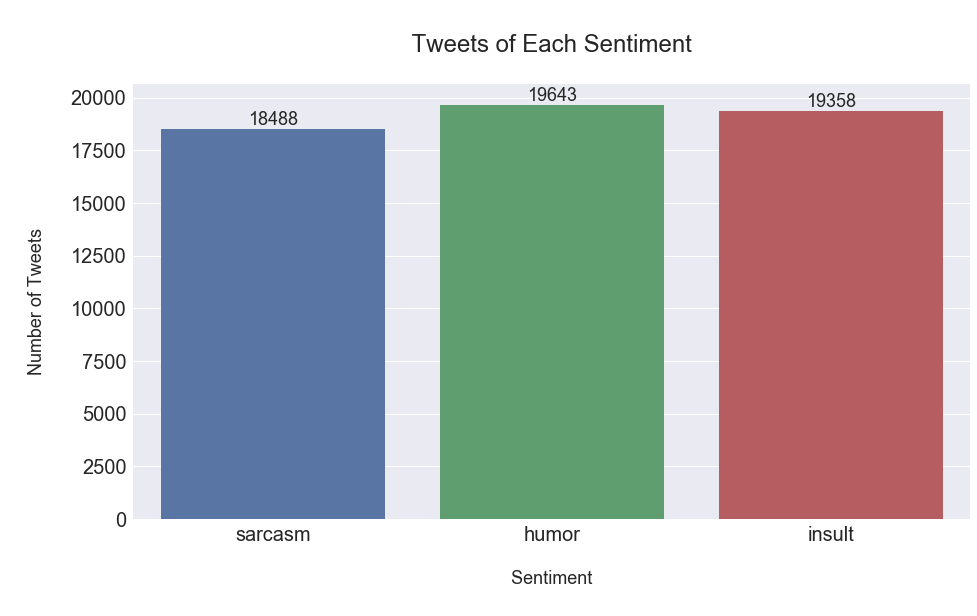

In [39]:
sns.set(font_scale = 2)
plt.figure(figsize=(15,8))

ax= sns.barplot(categories, data_raw.iloc[:,2:].sum().values)

plt.title("\n Tweets of Each Sentiment \n", fontsize=24)
plt.ylabel('\n Number of Tweets \n', fontsize=18)
plt.xlabel('\n Sentiment \n', fontsize=18)

#adding the text labels
rects = ax.patches
labels = data_raw.iloc[:,2:].sum().values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom', fontsize=18)

plt.show()

<h4>Divison of Tweets over Multiple Sentiments</h4>
<p>As evident from the graph, the highest number of Tweets are those with 1 sentiment only, then 2 sentiments and finally all three sentiments combined.</p>

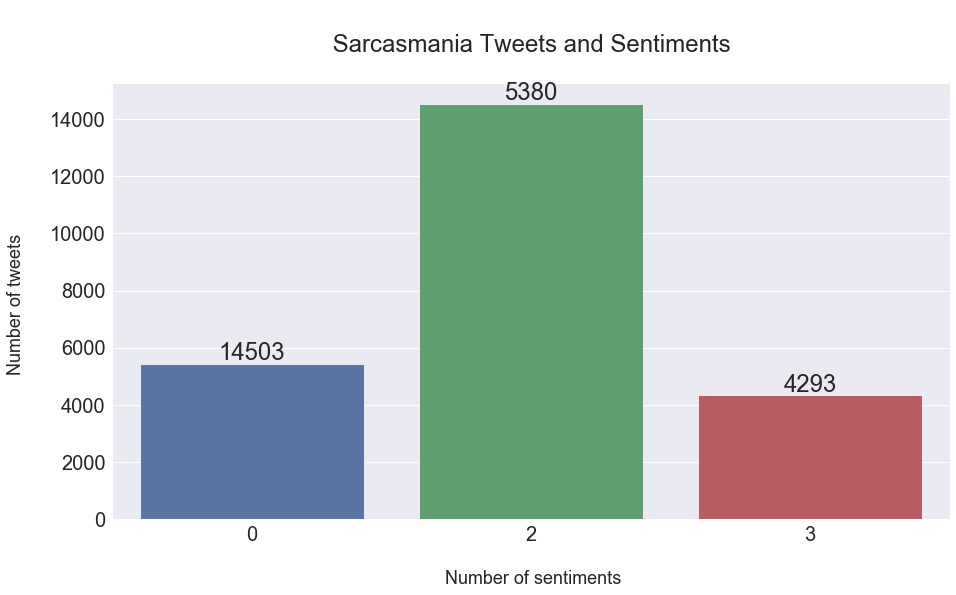

In [40]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

rowSums = data_raw.iloc[:,2:].sum(axis=1)
multiLabel_counts = rowSums.value_counts()
multiLabel_counts = multiLabel_counts.iloc[1:]
sns.set(font_scale = 2)
plt.figure(figsize=(15,8))
ax = sns.barplot(multiLabel_counts.index, multiLabel_counts.values)
plt.title("\n Sarcasmania Tweets and Sentiments \n")
plt.ylabel('Number of tweets \n', fontsize=18)
plt.xlabel('\n Number of sentiments', fontsize=18)
#adding the text labels
rects = ax.patches
labels = multiLabel_counts.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')
plt.show()

<h4>Word Cloud Per Sentiment</h4>
<p>A Cloud of most commin words per sentiment is shown below:</p>

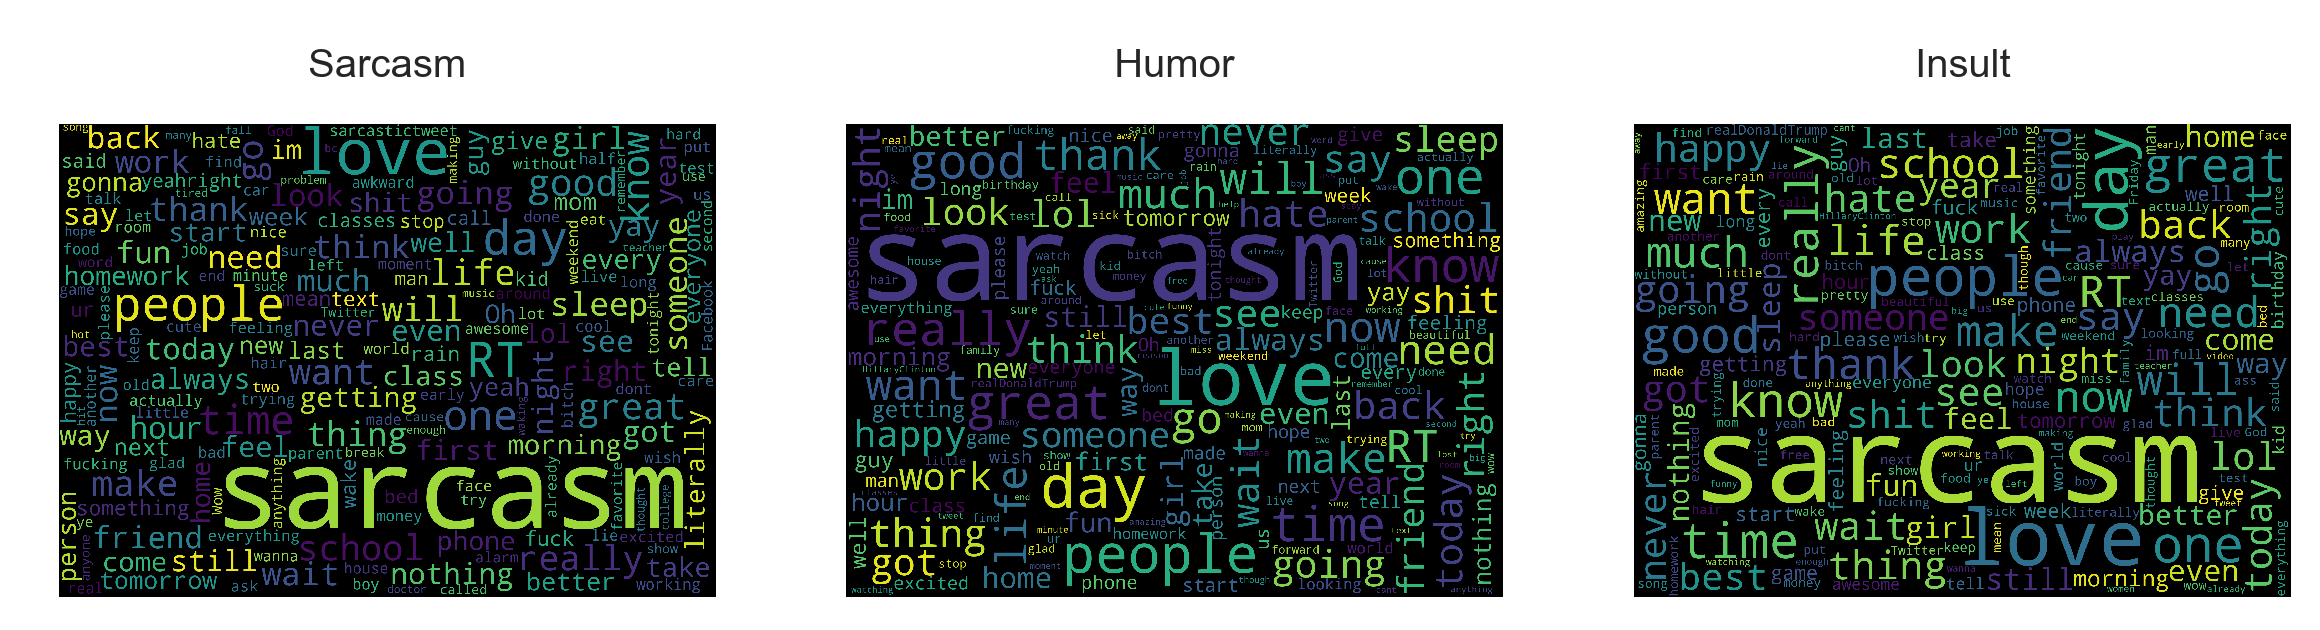

In [41]:
from wordcloud import WordCloud,STOPWORDS

plt.figure(figsize=(40,25))

# sarcasm
subset = data_raw[data_raw.sarcasm==1]
text = subset.tweet.values
cloud_sarcasm = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='black',
                          collocations=False,
                          width=2500,
                          height=1800
                         ).generate(" ".join(text))

plt.subplot(1, 3, 1)
plt.axis('off')
plt.title("\n Sarcasm \n",fontsize=40)
plt.imshow(cloud_sarcasm)


# Humor
subset = data_raw[data_raw.humor==1]
text = subset.tweet.values
cloud_humor = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='black',
                          collocations=False,
                          width=2500,
                          height=1800
                         ).generate(" ".join(text))

plt.subplot(1, 3, 2)
plt.axis('off')
plt.title("\n Humor \n",fontsize=40)
plt.imshow(cloud_humor)


# Insult
subset = data_raw[data_raw.insult==1]
text = subset.tweet.values
cloud_insult = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='black',
                          collocations=False,
                          width=2500,
                          height=1800
                         ).generate(" ".join(text))

plt.subplot(1, 3, 3)
plt.axis('off')
plt.title("\n Insult \n",fontsize=40)
plt.imshow(cloud_insult)

plt.show()

<h4>Loading Machine Learning Libraries:</h4>

In [3]:
from __future__ import print_function

import numpy as np
import h5py
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, GlobalMaxPooling1D, Conv1D, Embedding, MaxPooling1D
from keras.models import Model
from keras.models import load_model
from keras.initializers import Constant
import gensim.downloader as api
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

<h4>Loading Word Vectors:</h4>

In [4]:
TRAIN_TEXT_DATA_DIR = "sarcasmania-dataset.csv"
MAX_SEQUENCE_LENGTH = 100
MAX_NUM_WORDS = 20000
EMBEDDING_DIM = 300
VALIDATION_SPLIT = 0.2

info = api.info()
embedding_model = api.load("glove-wiki-gigaword-300")

vocab_size = len(embedding_model.vocab)

index2word = embedding_model.index2word
word2idx = {}
for index in range(vocab_size):
    word2idx[embedding_model.index2word[index]] = index

test = embedding_model.index2word

<h4>Pre-processing and Test/Train Data Split:</h4>

In [5]:
with open(TRAIN_TEXT_DATA_DIR) as f:
    tweets = pd.read_csv(TRAIN_TEXT_DATA_DIR)

prediction_labels = ["sarcasm", "humor", "insult"]
labels = tweets[prediction_labels].values

tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(tweets['tweet'].fillna("DUMMY_VALUE").values)
sequences = tokenizer.texts_to_sequences(tweets['tweet'].fillna("DUMMY_VALUE").values)
word_index = tokenizer.word_index

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

num_words = min(MAX_NUM_WORDS, len(word_index)) + 1
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    try:
        embedding_vector = embedding_model.get_vector(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    except:
        continue

embedding_layer = Embedding(len(word2idx),
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])
x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]

<h4>Model Compilation and Training</h4>

In [6]:
input_ = Input(shape=(MAX_SEQUENCE_LENGTH,))
x = embedding_layer(input_)
x = Conv1D(128, 5, activation='relu')(x)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 3, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(128, activation='relu')(x)
output = Dense(len(prediction_labels), activation='sigmoid')(x)
model = Model(input_, output)
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

history = model.fit(x_train, y_train, epochs=99, batch_size=512, validation_data=(x_val, y_val))

model.save('sarcasmania_model.h5')
del model 

Train on 31824 samples, validate on 7956 samples
Epoch 1/99
31824/31824 [==============================] - 53s 2ms/step - loss: 0.6633 - acc: 0.5669 - val_loss: 1.0903 - val_acc: 0.3373
Epoch 2/99
31824/31824 [==============================] - 46s 1ms/step - loss: 0.6395 - acc: 0.5877 - val_loss: 1.0080 - val_acc: 0.3909
Epoch 3/99
31824/31824 [==============================] - 47s 1ms/step - loss: 0.6181 - acc: 0.6059 - val_loss: 0.8614 - val_acc: 0.4607
Epoch 4/99
31824/31824 [==============================] - 56s 2ms/step - loss: 0.5991 - acc: 0.6277 - val_loss: 0.9602 - val_acc: 0.4699
Epoch 5/99
31824/31824 [==============================] - 57s 2ms/step - loss: 0.5815 - acc: 0.6470 - val_loss: 1.0601 - val_acc: 0.4562
Epoch 6/99
31824/31824 [==============================] - 57s 2ms/step - loss: 0.5595 - acc: 0.6648 - val_loss: 1.3054 - val_acc: 0.3953
Epoch 7/99
31824/31824 [==============================] - 64s 2ms/step - loss: 0.5344 - acc: 0.6874 - val_loss: 0.9397 - val_acc:

Epoch 60/99
31824/31824 [==============================] - 112s 4ms/step - loss: 0.0707 - acc: 0.9804 - val_loss: 3.6566 - val_acc: 0.4262
Epoch 61/99
31824/31824 [==============================] - 113s 4ms/step - loss: 0.0693 - acc: 0.9823 - val_loss: 3.6466 - val_acc: 0.4344
Epoch 62/99
31824/31824 [==============================] - 113s 4ms/step - loss: 0.0686 - acc: 0.9814 - val_loss: 3.7814 - val_acc: 0.4351
Epoch 63/99
31824/31824 [==============================] - 112s 4ms/step - loss: 0.0774 - acc: 0.9776 - val_loss: 3.3879 - val_acc: 0.4499
Epoch 64/99
31824/31824 [==============================] - 112s 4ms/step - loss: 0.0607 - acc: 0.9826 - val_loss: 3.4701 - val_acc: 0.4481
Epoch 65/99
31824/31824 [==============================] - 113s 4ms/step - loss: 0.0594 - acc: 0.9823 - val_loss: 3.2467 - val_acc: 0.4440
Epoch 66/99
31824/31824 [==============================] - 114s 4ms/step - loss: 0.0607 - acc: 0.9821 - val_loss: 3.6589 - val_acc: 0.4398
Epoch 67/99
31824/31824 [==

<h4>Test/Train Accuracy Plot:</h4>

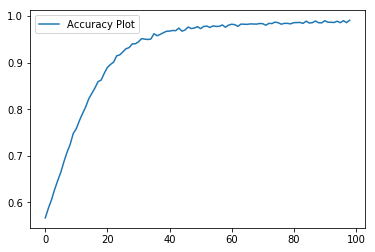

In [9]:
plt.plot(history.history['acc'], label='Accuracy Plot')
plt.legend()
plt.show()

<h4>Train Model Accuracy:</h4>

In [12]:
print("Sarcasmania Model Accuracy: ", history.history['acc'][-1]*100, "%.")

Sarcasmania Model Accuracy:  99.08454961486652 %.


<h4>Model Predictions:</h4>

In [14]:
model = load_model('sarcasmania_model.h5')

In [16]:
def create_prediction(model, sequence, tokenizer, max_length, prediction_labels):
    # Convert the sequence to tokens and pad it.
    sequence = tokenizer.texts_to_sequences(sequence)
    sequence = pad_sequences(sequence, maxlen=max_length)
    
    # Make a prediction
    sequence_prediction = model.predict(sequence, verbose=1)
    
    # Take only the first of the batch of predictions
    sequence_prediction = pd.DataFrame(sequence_prediction).round(3)
    
    # Label the predictions
    sequence_prediction.columns = prediction_labels
    return sequence_prediction

<h4>Sample Prediction</h4>

In [17]:
sequence = [input("Please input a sentence: ")]
prediction = create_prediction(model, sequence, tokenizer, MAX_SEQUENCE_LENGTH, prediction_labels)
print("Sarcasmania Prediction: \n", prediction)

Please input a sentence: I'm almost gonna miss doing my homework #not #sarcasm
1/1 [==============================] - 0s 2ms/step
Sarcasmania Prediction: 
    sarcasm  humor  insult
0      1.0    0.0     0.0
